In [1]:
import colormaps as cmaps
import connectorx  # noqa: F401
import matplotlib.pyplot as plt
import opinionated  # noqa: F401
import polars as pl
import seaborn as sns

from rs_graph.db import constants as db_constants

plt.style.use("opinionated_rc")

CMAPS_BOLD_PALETTE = cmaps.bold._colors.tolist()

###############################################################################


def _read_table(table: str) -> pl.DataFrame:
    return pl.read_database_uri(
        f"SELECT * FROM {table}",
        f"sqlite:///{db_constants.V2_DATABASE_PATHS.dev}",
    )


def load_pairs() -> pl.DataFrame:
    # Read all the tables we need
    dataset_sources = _read_table("dataset_source")
    docs = _read_table("document")
    repos = _read_table("repository")
    pairs = _read_table("document_repository_link")
    doc_topics = _read_table("document_topic")
    topics = _read_table("topic")

    # Drop to unique doc and unique repo in pairs
    pairs = pairs.unique(
        subset="document_id",
        keep="none",
    ).unique(
        subset="repository_id",
        keep="none",
    )

    # Create a table of document_authors
    # and their country institutional affiliations
    # then group by document to get to document_country_affiliation
    doc_contribs = _read_table("document_contributor")
    doc_contrib_institutions = _read_table("document_contributor_institution")
    institutions = _read_table("institution")

    doc_author_countries = (
        doc_contribs.select(
            pl.col("id").alias("document_contributor_id"),
            pl.col("researcher_id"),
            pl.col("document_id"),
        )
        .join(
            doc_contrib_institutions.select(
                "document_contributor_id",
                "institution_id",
            ),
            on="document_contributor_id",
            how="left",
        )
        .join(
            institutions.select(
                pl.col("id").alias("institution_id"),
                "country_code",
            ),
            on="institution_id",
            how="left",
        )
        .with_columns(
            pl.when(pl.col("country_code").is_null())
            .then(pl.lit("Unknown"))
            .otherwise(pl.col("country_code"))
        )
        .group_by("document_id")
        .agg(
            pl.len().alias("document_n_authors"),
            pl.when(pl.col("country_code").n_unique() == 1)
            .then(pl.col("country_code").get(0))
            .otherwise(pl.lit("Multiple")),
        )
        .with_columns(
            pl.when(pl.col("country_code").is_null())
            .then(pl.lit("Unknown"))
            .otherwise(pl.col("country_code"))
            .alias("country_code")
        )
    )

    # Get repo_contribs count
    repo_contribs = _read_table("repository_contributor")
    repo_contribs = repo_contribs.group_by("repository_id").len("repository_n_contributors")

    # Join the tables to get the positive examples
    return (
        pairs.select(
            "document_id",
            "repository_id",
            "dataset_source_id",
            pl.col("predictive_model_confidence").alias("document_repository_link_confidence"),
        )
        .join(
            docs.select(
                pl.col("id").alias("document_id"),
                pl.col("cited_by_count").alias("document_cited_by_count"),
                pl.col("fwci").alias("document_fwci"),
                pl.col("is_open_access").alias("document_is_open_access"),
                pl.col("publication_date").alias("document_publication_date"),
            ),
            on="document_id",
            how="left",
        )
        .join(
            repos.select(
                pl.col("id").alias("repository_id"),
                pl.col("stargazers_count").alias("repository_stargazers_count"),
                pl.col("commits_count").alias("repository_commits_count"),
                pl.col("primary_language").alias("repository_primary_language"),
                pl.col("creation_datetime").alias("repository_creation_datetime"),
                pl.col("last_pushed_datetime").alias("repository_last_pushed_datetime"),
            ),
            on="repository_id",
            how="left",
        )
        .join(
            dataset_sources.select(
                pl.col("id").alias("dataset_source_id"),
                pl.col("name").alias("dataset_source_name"),
            ),
            on="dataset_source_id",
            how="left",
        )
        .join(
            doc_topics.sort(
                "score",
                descending=True,
            )
            .unique(
                "document_id",
                maintain_order=True,
            )
            .select(
                pl.col("document_id").alias("document_id"),
                pl.col("topic_id").alias("topic_id"),
            ),
            on="document_id",
            how="left",
        )
        .join(
            topics.select(
                pl.col("id").alias("topic_id"),
                pl.col("domain_name").alias("document_domain_name"),
                pl.col("field_name").alias("document_field_name"),
            ),
            on="topic_id",
            how="left",
        )
        .join(
            doc_author_countries,
            on="document_id",
            how="left",
        )
        .join(
            repo_contribs,
            on="repository_id",
            how="left",
        )
    )


df = load_pairs()
df

# Drop any rows with document_repository_link_confidence of less than 0.995
df = df.filter(
    (pl.col("document_repository_link_confidence") >= 0.995)
    | (pl.col("document_repository_link_confidence").is_null())
)

# Get consistent hue order and col order by sorting the dataset source names
dataset_source_names = (
    df.select("dataset_source_name")
    .unique()
    .sort("dataset_source_name")["dataset_source_name"]
    .to_list()
)

df

/Users/evamaxfield/micromamba/envs/rs-graph/lib/python3.13/site-packages/opinionated/__init__.py:24: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Now downloading: Roboto Condensed
Added new font as Roboto Condensed Light
Added new font as Roboto Condensed
Added new font as Roboto Condensed
Added new font as Roboto Condensed Black
Now downloading: Montserrat
Added new font as Montserrat Thin Light
Added new font as Montserrat Thin
Added new font as Montserrat Thin
Added new font as Montserrat Thin Black
Now downloading: Source Code Pro
Added new font as Source Code Pro ExtraLight Light
Added new font as Source Code Pro ExtraLight
Added new font as Source Code Pro ExtraLight
Added new font as Source Code Pro ExtraLight Black
Now downloading: Fira Sans
Added new font as Fira Sans Light
Added new font as Fira Sans
Added new font as Fira Sans
Added new font as Fira Sans Black
Now downloading: Fira Sans Condensed
Added new font as Fira Sans Condensed Light
Added new font as Fira Sans Condensed
Added new font as Fira Sans Condensed
Added new font as Fira Sans Condensed Black
Now downloading: IBM Plex Sans
Added new font as IBM Plex San

document_id,repository_id,dataset_source_id,document_repository_link_confidence,document_cited_by_count,document_fwci,document_is_open_access,document_publication_date,repository_stargazers_count,repository_commits_count,repository_primary_language,repository_creation_datetime,repository_last_pushed_datetime,dataset_source_name,topic_id,document_domain_name,document_field_name,document_n_authors,country_code,repository_n_contributors
i64,i64,i64,f64,i64,f64,bool,date,i64,i64,str,datetime[ns],datetime[ns],str,i64,str,str,u32,str,u32
1,1,1,null,0,0.0,true,2025-12-21,3,35,"""Python""",2025-05-22 15:42:12,2025-12-20 21:55:57,"""joss""",1,"""Physical Sciences""","""Environmental Science""",4,"""US""",1
2,2,1,null,0,0.0,true,2025-12-26,6,694,"""Python""",2025-03-30 23:16:39,2025-12-27 03:02:16,"""joss""",4,"""Physical Sciences""","""Engineering""",1,"""JP""",2
3,3,1,null,0,null,true,2026-01-07,1,100,"""Python""",2025-02-12 13:56:45,2025-12-05 14:52:32,"""joss""",7,"""Physical Sciences""","""Computer Science""",1,"""BR""",2
4,4,1,null,0,0.0,true,2025-12-22,19,224,"""GDScript""",2024-06-10 07:01:58,2025-12-19 14:03:48,"""joss""",10,"""Life Sciences""","""Biochemistry, Genetics and Mol…",6,"""Multiple""",2
5,5,1,null,0,0.0,true,2025-12-30,3,272,"""Python""",2025-03-21 22:58:29,2025-12-31 10:32:44,"""joss""",13,"""Physical Sciences""","""Computer Science""",5,"""Multiple""",3
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
150369,147852,4,null,68,5.32575,true,2019-07-05,4,7,"""Fortran""",2017-10-13 15:30:50,2018-09-22 13:29:18,"""plos""",805,"""Life Sciences""","""Neuroscience""",4,"""GB""",1
150370,147853,4,null,26,3.55297,true,2022-12-15,1,52,"""HTML""",2021-05-03 18:08:00,2022-11-08 15:57:37,"""plos""",406,"""Physical Sciences""","""Environmental Science""",10,"""Multiple""",1
150371,147854,4,null,10,1.237918,true,2022-07-14,4,5,"""Python""",2022-05-26 12:44:46,2022-05-26 16:40:33,"""plos""",235,"""Physical Sciences""","""Computer Science""",4,"""Multiple""",1


# Summary of Sample

In [2]:
basic_stats_template = """
Our sample consists of {n_articles} articles-repository pairs.
The geographic distribution of authorship teams includes {n_countries} countries, with the most frequent being {top_five_countries}.
The articles span {n_years} years, from {min_year} to {max_year}, with a median publication year of {median_year}.
The most frequent research field is {top_field} ({top_field_count} articles, {top_field_percent:.1f}%).
The top five research fields are: {top_five_fields}.
The most frequent programming language is {top_language} ({top_language_count} articles, {top_language_percent:.1f}%).
The top five programming languages are: {top_five_languages}.
""".strip()

n_articles = df.height
n_countries = df.select("country_code").n_unique()
top_countries = (
    df.group_by("country_code")
    .len("count")
    .sort("count", descending=True)
    .limit(5)
    .select("country_code")
    .to_series()
    .to_list()
)
top_five_countries = ", ".join([f"'{c}'" for c in top_countries])
n_years = (
    df.select(pl.col("document_publication_date").dt.year())
    .unique()
    .height
)
min_year = int(df["document_publication_date"].dt.year().min())
max_year = int(df["document_publication_date"].dt.year().max())
median_year = int(df["document_publication_date"].dt.year().median())
top_field_df = (
    df.group_by("document_field_name")
    .len("count")
    .sort("count", descending=True)
    .limit(1)
)
top_field = top_field_df.select("document_field_name").to_series()[0]
top_field_count = top_field_df.select("count").to_series()[0]
top_field_percent = (top_field_count / n_articles) * 100
top_five_fields_df = (
    df.group_by("document_field_name")
    .len("count")
    .sort("count", descending=True)
    .limit(5)
)
top_five_fields = ", ".join(
    [f"'{f}'" for f in top_five_fields_df.select("document_field_name").to_series().to_list()]
)
top_language_df = (
    df.group_by("repository_primary_language")
    .len("count")
    .sort("count", descending=True)
    .limit(1)
)
top_language = top_language_df.select("repository_primary_language").to_series()[0]
top_language_count = top_language_df.select("count").to_series()[0]
top_language_percent = (top_language_count / n_articles) * 100
top_five_languages_df = (
    df.group_by("repository_primary_language")
    .len("count")
    .sort("count", descending=True)
    .limit(5)
)
top_five_languages = ", ".join(
    [f"'{l}'" for l in top_five_languages_df.select("repository_primary_language").to_series().to_list()]
)

basic_stats = basic_stats_template.format(
    n_articles=n_articles,
    n_countries=n_countries,
    top_five_countries=top_five_countries,
    n_years=n_years,
    min_year=min_year,
    max_year=max_year,
    median_year=median_year,
    top_field=top_field,
    top_field_count=top_field_count,
    top_field_percent=top_field_percent,
    top_five_fields=top_five_fields,
    top_language=top_language,
    top_language_count=top_language_count,
    top_language_percent=top_language_percent,
    top_five_languages=top_five_languages,
)
print(basic_stats)

Our sample consists of 135072 articles-repository pairs.
The geographic distribution of authorship teams includes 100 countries, with the most frequent being 'Unknown', 'Multiple', 'US', 'CN', 'DE'.
The articles span 23 years, from 2003 to 2026, with a median publication year of 2023.
The most frequent research field is Computer Science (81126 articles, 60.1%).
The top five research fields are: 'Computer Science', 'Engineering', 'Physics and Astronomy', 'Medicine', 'Biochemistry, Genetics and Molecular Biology'.
The most frequent programming language is Python (81910 articles, 60.6%).
The top five programming languages are: 'Python', 'Jupyter Notebook', 'None', 'R', 'C++'.


<Axes: xlabel='count', ylabel='country_code'>

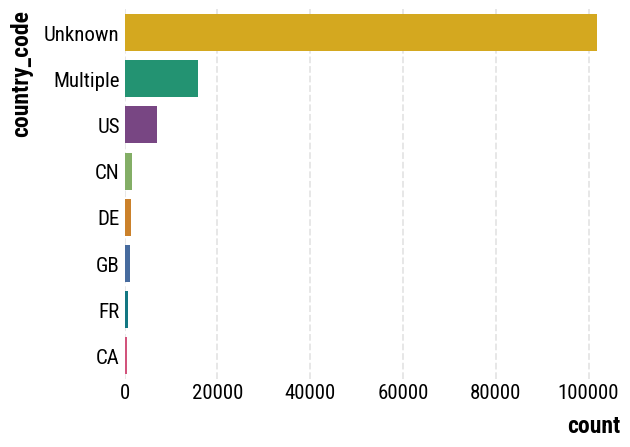

In [3]:
top_eight_countries = (
    df.group_by("country_code")
    .len("count")
    .sort("count", descending=True)
    .limit(8)
    .select("country_code")
    .to_series()
    .to_list()
)

sns.countplot(
    data=df.filter(pl.col("country_code").is_in(top_eight_countries)),
    y="country_code",
    hue="country_code",
    order=top_eight_countries,
    palette=CMAPS_BOLD_PALETTE[:8],
)

<Axes: xlabel='count', ylabel='document_field_name'>

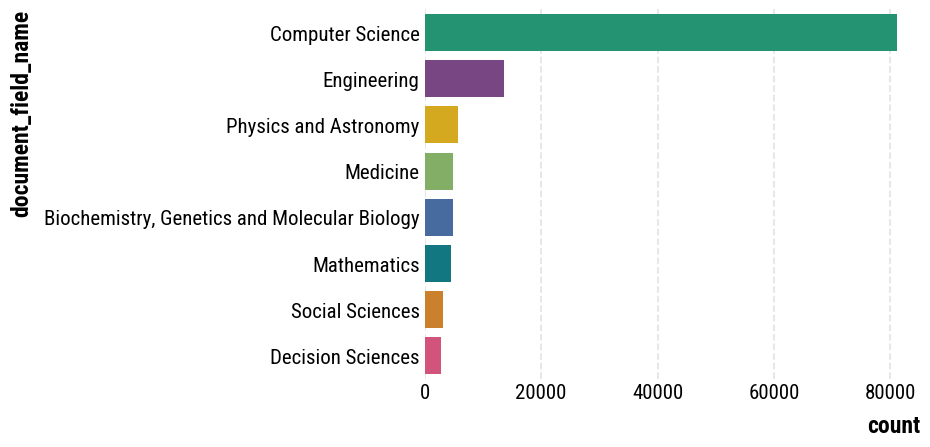

In [4]:
top_eight_fields = (
    df.group_by("document_field_name")
    .len("count")
    .sort("count", descending=True)
    .limit(8)
    .select("document_field_name")
    .to_series()
    .to_list()
)

sns.countplot(
    data=df.filter(pl.col("document_field_name").is_in(top_eight_fields)),
    y="document_field_name",
    hue="document_field_name",
    order=top_eight_fields,
    palette=CMAPS_BOLD_PALETTE[:8],
)

<Axes: xlabel='document_publication_date', ylabel='Count'>

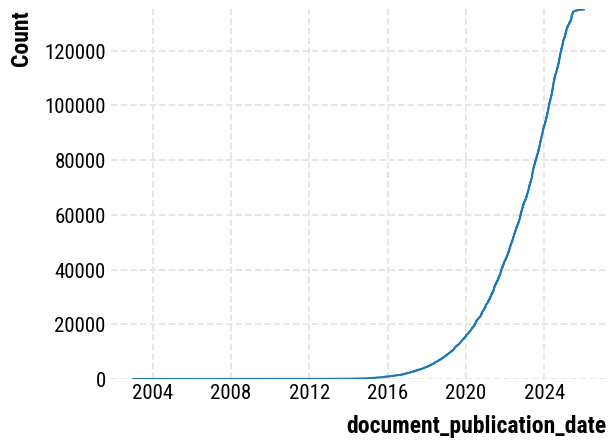

In [5]:
# Plot cumulative publications over time
sns.ecdfplot(
    data=df.with_columns(
        pl.col("document_publication_date"),
    ),
    x="document_publication_date",
    stat="count",
)

<Axes: xlabel='count', ylabel='repository_primary_language'>

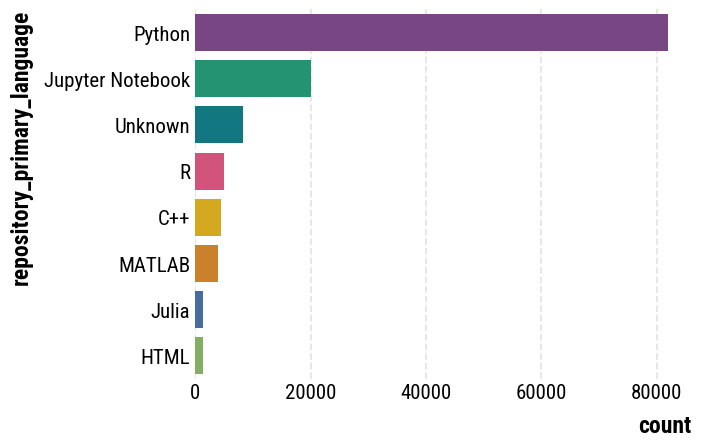

In [6]:
# Replace None with 'Unknown' for plotting
df = df.with_columns(
    pl.when(pl.col("repository_primary_language").is_null())
    .then(pl.lit("Unknown"))
    .otherwise(pl.col("repository_primary_language"))
    .alias("repository_primary_language")
)

top_eight_languages = (
    df.group_by("repository_primary_language")
    .len("count")
    .sort("count", descending=True)
    .limit(8)
    .select("repository_primary_language")
    .to_series()
    .to_list()
)

sns.countplot(
    data=df.filter(pl.col("repository_primary_language").is_in(top_eight_languages)),
    y="repository_primary_language",
    hue="repository_primary_language",
    order=top_eight_languages,
    palette=CMAPS_BOLD_PALETTE[:8],
)

# Timedelta Comparisons

In [7]:
# Create additional columns for
# - days_between_repo_creation_and_repo_last_pushed
# - days_between_repo_creation_and_article_publication
# - days_between_article_publication_and_repo_last_pushed

# Date columns available:
# - repository_creation_datetime
# - repository_last_pushed_datetime
# - document_publication_date

# Convert all date columns to datetime[ns]
df = df.with_columns(
    pl.col("repository_creation_datetime").cast(pl.Datetime(time_unit="ns")),
    pl.col("repository_last_pushed_datetime").cast(pl.Datetime(time_unit="ns")),
    pl.col("document_publication_date").cast(pl.Datetime(time_unit="ns")),
)

df = df.with_columns(
    (pl.col("repository_last_pushed_datetime") - pl.col("repository_creation_datetime"))
    .dt.total_days()
    .alias("days_between_repo_creation_and_repo_last_pushed"),
    (pl.col("document_publication_date") - pl.col("repository_creation_datetime"))
    .dt.total_days()
    .alias("days_between_repo_creation_and_article_publication"),
    (pl.col("repository_last_pushed_datetime") - pl.col("document_publication_date"))
    .dt.total_days()
    .alias("days_between_article_publication_and_repo_last_pushed"),
)

timedelta_stats_template = """
Days between repository creation and last push: minimum {min_days_repo_creation_to_last_push} days, maximum {max_days_repo_creation_to_last_push} days, median {median_days_repo_creation_to_last_push} days.
Days between repository creation and article publication: minimum {min_days_repo_creation_to_article_pub} days, maximum {max_days_repo_creation_to_article_pub} days, median {median_days_repo_creation_to_article_pub} days.
Days between article publication and repository last push: minimum {min_days_article_pub_to_last_push} days, maximum {max_days_article_pub_to_last_push} days, median {median_days_article_pub_to_last_push} days.
""".strip()

timedelta_stats = timedelta_stats_template.format(
    min_days_repo_creation_to_last_push=int(df["days_between_repo_creation_and_repo_last_pushed"].min()),
    max_days_repo_creation_to_last_push=int(df["days_between_repo_creation_and_repo_last_pushed"].max()),
    median_days_repo_creation_to_last_push=int(df["days_between_repo_creation_and_repo_last_pushed"].median()),
    min_days_repo_creation_to_article_pub=int(df["days_between_repo_creation_and_article_publication"].min()),
    max_days_repo_creation_to_article_pub=int(df["days_between_repo_creation_and_article_publication"].max()),
    median_days_repo_creation_to_article_pub=int(df["days_between_repo_creation_and_article_publication"].median()),
    min_days_article_pub_to_last_push=int(df["days_between_article_publication_and_repo_last_pushed"].min()),
    max_days_article_pub_to_last_push=int(df["days_between_article_publication_and_repo_last_pushed"].max()),
    median_days_article_pub_to_last_push=int(df["days_between_article_publication_and_repo_last_pushed"].median()),
)

print(timedelta_stats)

Days between repository creation and last push: minimum -1808 days, maximum 6225 days, median 239 days.
Days between repository creation and article publication: minimum -5922 days, maximum 5465 days, median 17 days.
Days between article publication and repository last push: minimum -4078 days, maximum 6826 days, median 189 days.


<Axes: xlabel='days_between_repo_creation_and_repo_last_pushed', ylabel='Percent'>

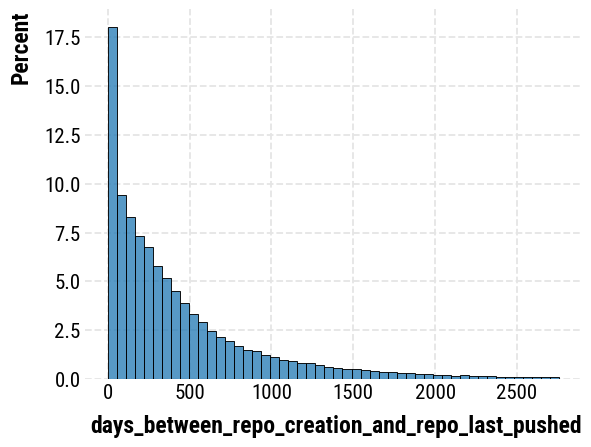

In [8]:
# Plot distribution of days_between_repo_creation_and_repo_last_pushed
sns.histplot(
    data=df.filter(
        pl.col("days_between_repo_creation_and_repo_last_pushed") < pl.col("days_between_repo_creation_and_repo_last_pushed").quantile(0.99),
        pl.col("days_between_repo_creation_and_repo_last_pushed") > pl.col("days_between_repo_creation_and_repo_last_pushed").quantile(0.01),
    ),
    x="days_between_repo_creation_and_repo_last_pushed",
    bins=50,
    stat="percent",
)

<Axes: xlabel='days_between_repo_creation_and_article_publication', ylabel='Percent'>

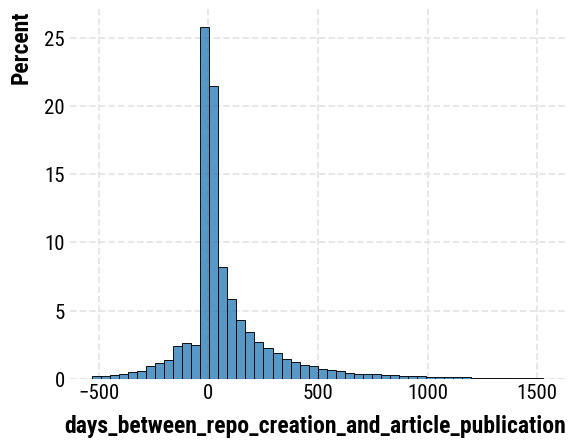

In [9]:
# Plot distribution of days_between_repo_creation_and_article_publication
sns.histplot(
    data=df.filter(
        pl.col("days_between_repo_creation_and_article_publication") < pl.col("days_between_repo_creation_and_article_publication").quantile(0.99),
        pl.col("days_between_repo_creation_and_article_publication") > pl.col("days_between_repo_creation_and_article_publication").quantile(0.01),
    ),
    x="days_between_repo_creation_and_article_publication",
    bins=50,
    stat="percent",
)

<Axes: xlabel='days_between_article_publication_and_repo_last_pushed', ylabel='Percent'>

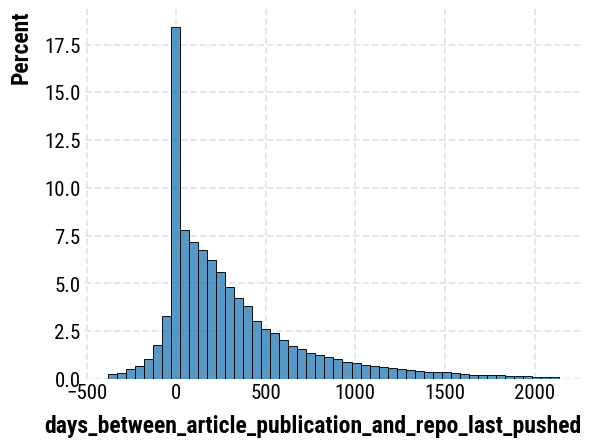

In [10]:
# Plot distribution of days_between_article_publication_and_repo_last_pushed
sns.histplot(
    data=df.filter(
        pl.col("days_between_article_publication_and_repo_last_pushed") < pl.col("days_between_article_publication_and_repo_last_pushed").quantile(0.99),
        pl.col("days_between_article_publication_and_repo_last_pushed") > pl.col("days_between_article_publication_and_repo_last_pushed").quantile(0.01),
    ),
    x="days_between_article_publication_and_repo_last_pushed",
    bins=50,
    stat="percent",
)

/Users/evamaxfield/micromamba/envs/rs-graph/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)


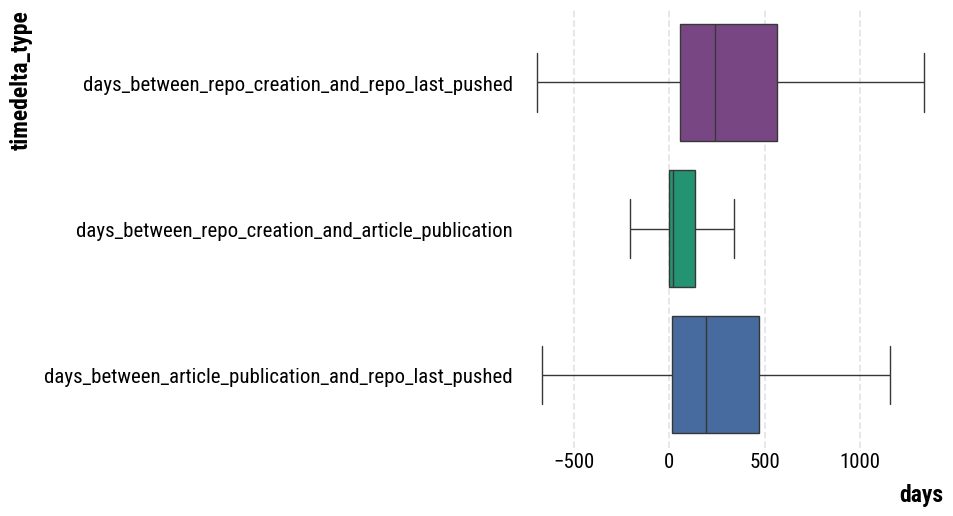

In [11]:
# Melt columns so that we can plot all three distributions as box plots together
timedelta_melted = df.unpivot(
    on=[
        "days_between_repo_creation_and_repo_last_pushed",
        "days_between_repo_creation_and_article_publication",
        "days_between_article_publication_and_repo_last_pushed",
    ],
    index=["document_id", "repository_id"],
    variable_name="timedelta_type",
    value_name="days",
)

g = sns.catplot(
    data=timedelta_melted,
    x="days",
    y="timedelta_type",
    hue="timedelta_type",
    kind="box",
    palette=CMAPS_BOLD_PALETTE[:3],
    showfliers=False,
)

One might suggest that the common pattern of scientific source code availability is "code dumping," where code is made available very close to the date of article publication, with little subsequent development. To investigate this, we compute three time deltas:

1. Days between repository creation and last pushed date
2. Days between repository creation and article publication date
3. Days between article publication date and repository last pushed date

We find that while there is a peak around zero days for all three time deltas, there is also a wide distribution of values, indicating that many repositories were created well before article publication and/or continued to be developed well after article publication.

Additionally, we observe that there are ~25% of repositories that contained development tied to a different repository that were then transferred to a public repository (as indicated by the negative values in the "days between repository creation and repository last pushed date"). Similarly, ~25% of repositories were created after the article publication date, an addition ~25% of repositories have near zero days between article publication and repository last pushed date, suggesting that code dumping is a common practice. However, the third timedelta (days between article publication date and repository last pushed date) shows a long tail of continued development after article publication, indicating that many repositories are actively maintained beyond the initial code dump. I additionally shows that there are some "negative" values here, indicating that some repositories were last pushed to before the article publication date, suggesting that the code development for the project was completed long before the article was published.